## Importing Needed Libraries

In [1]:
import os
import PIL as Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

print('modules loaded')

2024-07-29 18:31:43.556565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 18:31:43.556697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 18:31:43.694004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


## Reading The Dataset

In [2]:
data_dir='/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    file_path=os.path.join(data_dir,fold)
    if not os.path.isdir(file_path): # if not a directory, skip
        continue
    fpath = os.listdir(file_path)
    
    for f in fpath:
        fil_path=os.path.join(file_path,f)
        filepath.append(fil_path)
        labels.append(fold)

f_series=pd.Series(filepath,name='filepaths')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series, l_series], axis= 1)

In [3]:
df.head()

,filepaths,labels
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


## EDA

In [4]:
df['labels'].value_counts().sort_index()

labels
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64

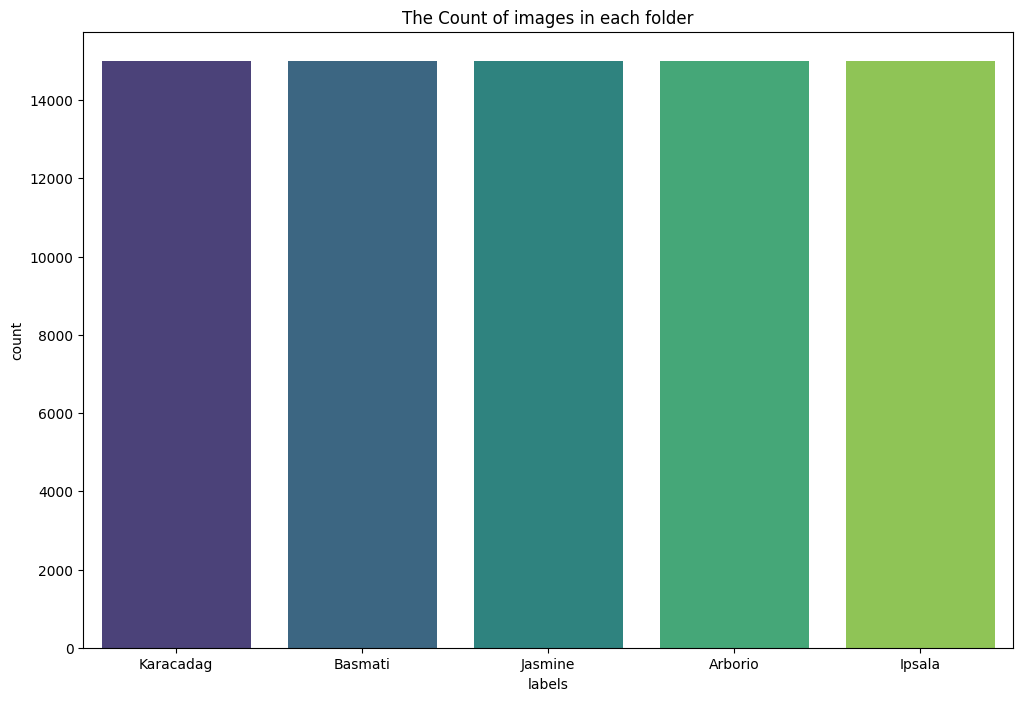

In [5]:
plt.figure(figsize=(12,8))
sns.barplot(x=df['labels'].value_counts().index,y=df['labels'].value_counts().values,palette='viridis')
plt.title('The Count of images in each folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

## Preprocessing The Data

**Splitting The Dataset into Train, Test, and Validate Sets**

In [6]:
train_df,dummy_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df['labels'])
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=dummy_df['labels'])

**Creating Image Data Genearator**

In [7]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


**Displaying a Sample from The Data**

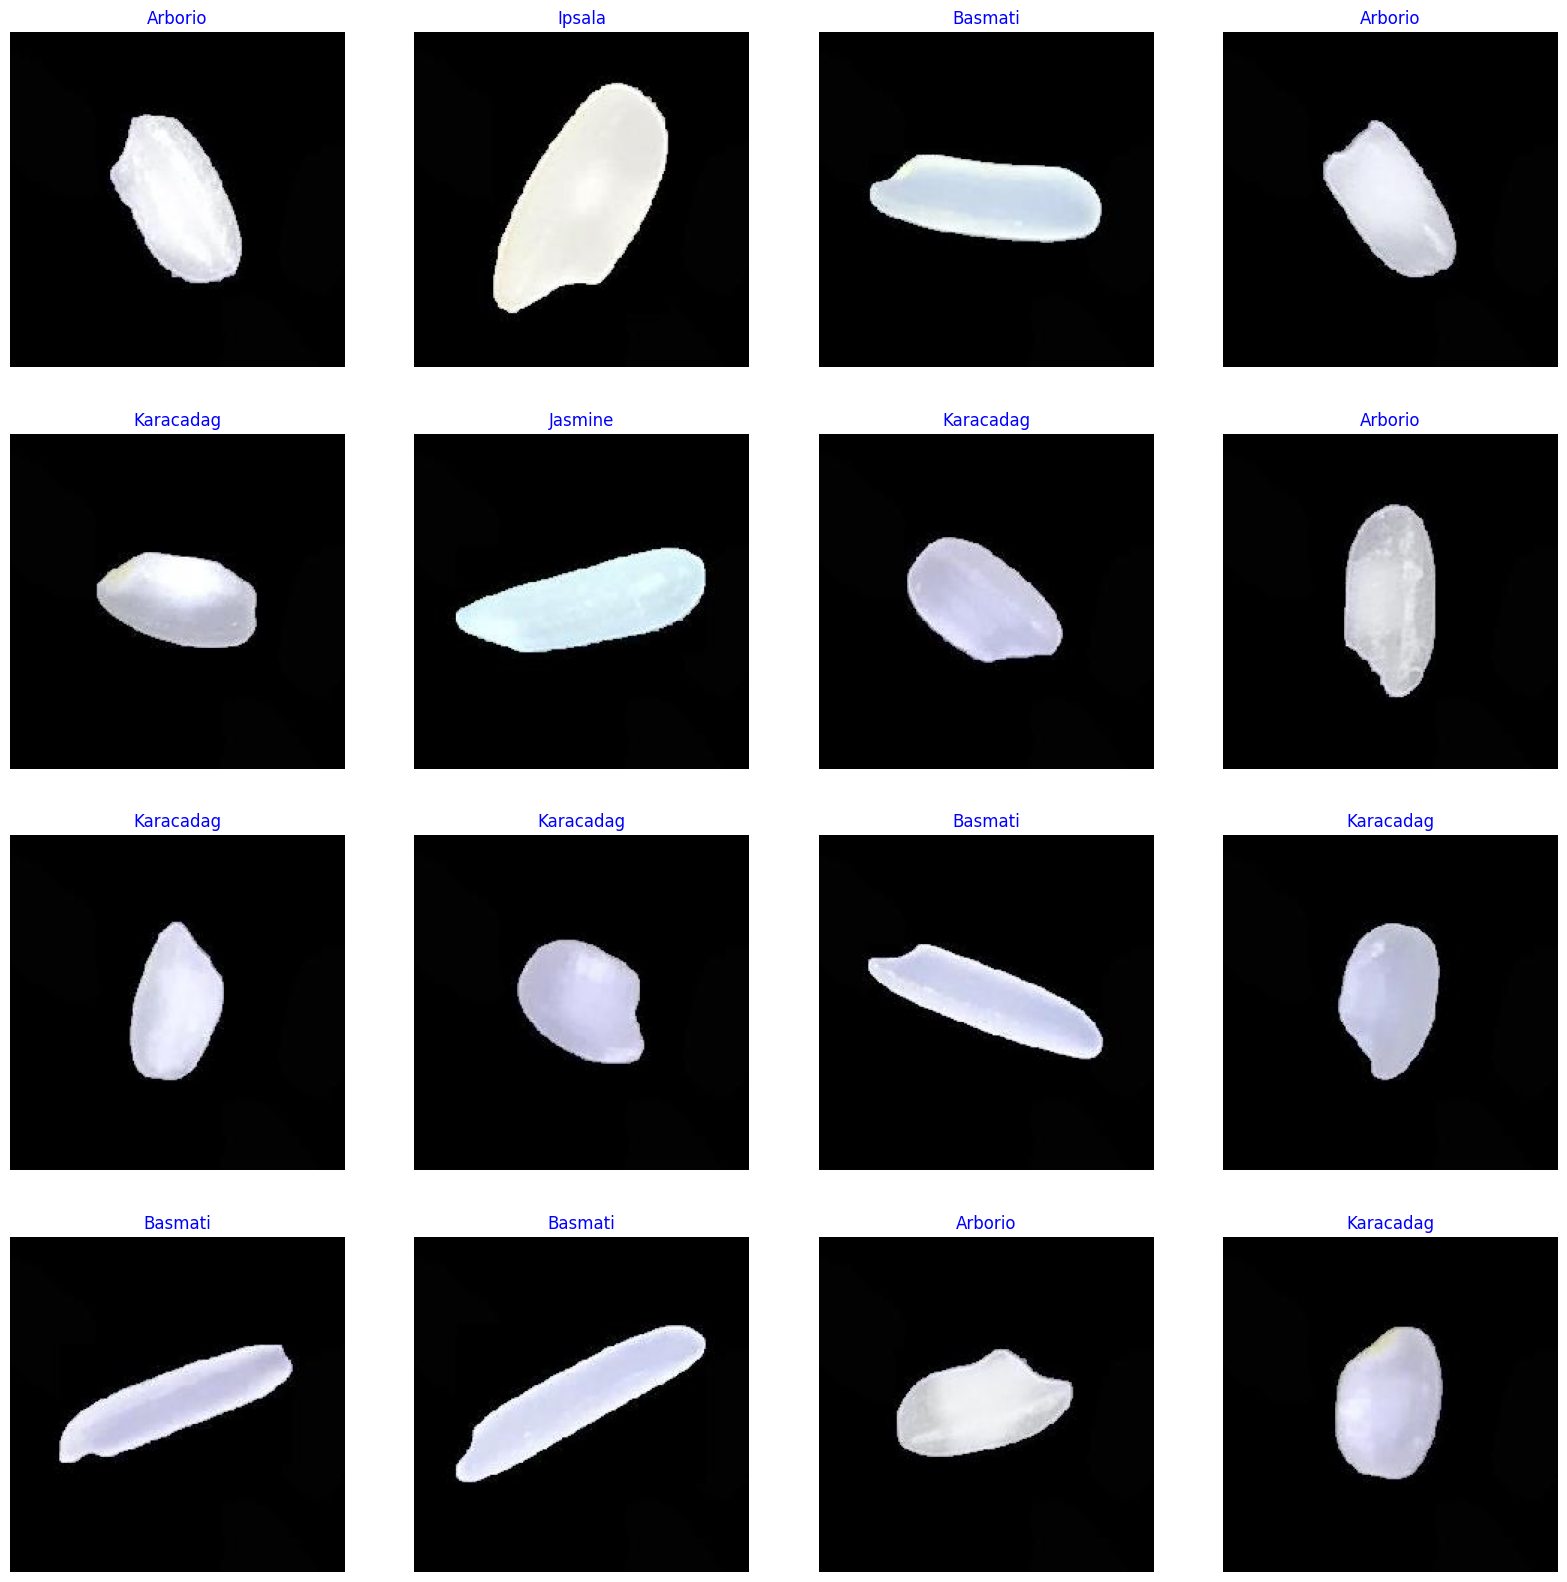

In [8]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Pre-Trained Model

**Generic Model Creation**

In [9]:
# Define image size and shape
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Determine the number of classes from the training generator
class_count = len(list(train_gen.class_indices.keys()))

# Create the base model using ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Add custom layers on top of the base model
x = base_model.output
x = Dense(128, activation='relu')(x)
predictions = Dense(class_count, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with optimizer and loss function
optimizer = Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 23,797,509 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

**Train Model**

In [10]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with frozen layers
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722278155.748018      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722278155.853575      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9637 - loss: 0.5518

W0000 00:00:1722278605.754721      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.02563, saving model to best_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 589s 538ms/step - accuracy: 0.9637 - loss: 0.5513 - val_accuracy: 0.9917 - val_loss: 0.0256
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9971 - loss: 0.0096
Epoch 2: val_loss did not improve from 0.02563
938/938 ━━━━━━━━━━━━━━━━━━━━ 278s 295ms/step - accuracy: 0.9971 - loss: 0.0096 - val_accuracy: 0.9923 - val_loss: 0.0348
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9949 - loss: 0.0203
Epoch 3: val_loss improved from 0.02563 to 0.00549, saving model to best_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 280s 297ms/step - accuracy: 0.9949 - loss: 0.0203 - val_accuracy: 0.9991 - val_loss: 0.0055
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9974 - loss: 0.0083
Epoch 4: val_loss did not improve from 0.00549
938/938 ━━━━━━━━━━━━━━━━━━━━ 278s 295ms/step - accuracy: 0.9974 - loss: 0.0083 - val_accuracy: 0.9981 - val_loss

**Display Model Performance**

In [11]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

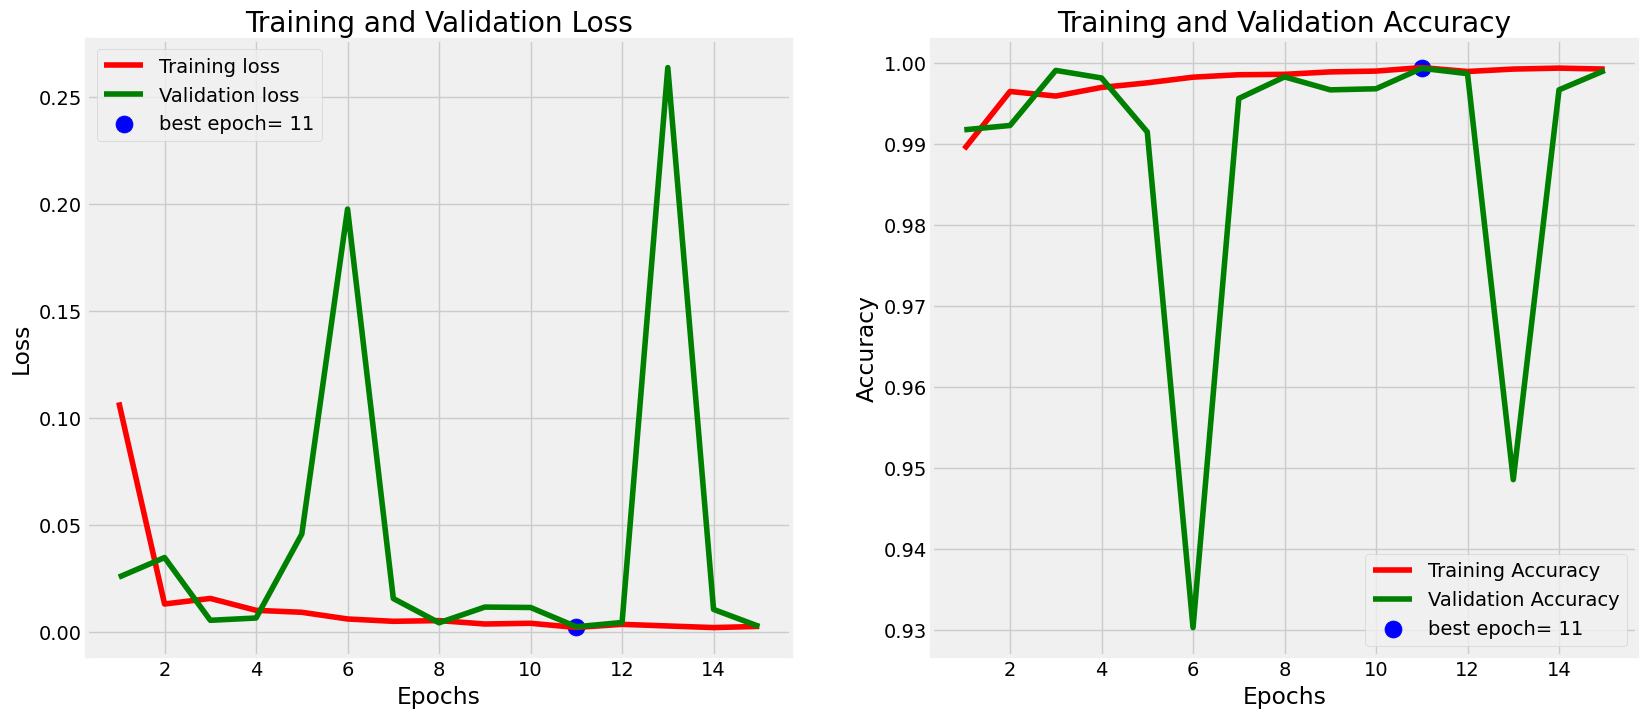

In [12]:
plot_training(history)

**Evaluate Model**

In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 1.0000 - loss: 4.0235e-04
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.9995 - loss: 0.0013


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 481ms/step - accuracy: 0.9995 - loss: 0.0014
Train Loss:  0.0004503088421188295
Train Accuracy:  0.9998437762260437
--------------------
Validation Loss:  0.0016756850527599454
Validation Accuracy:  0.9993749856948853
--------------------
Test Loss:  0.0025715306401252747
Test Accuracy:  0.999218761920929


**Confusion Matrix**

  3/118 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step

W0000 00:00:1722282667.750765      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step


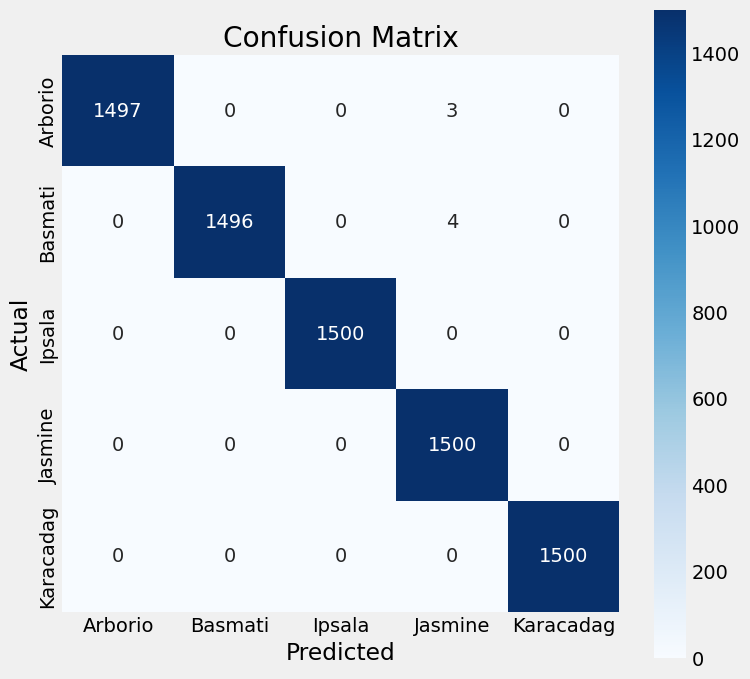

In [14]:
# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# # Plot confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Tuning The Model**

In [15]:
# Load the saved model
model = tf.keras.models.load_model('best_model.keras')

# Unfreeze some of the deeper layers for fine-tuning
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
optimizer = Adamax(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary after unfreezing
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 23,797,509 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

**Training The Fine-Tuned Model**

In [16]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_finetuned_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Fine-tune the model with the unfrozen layers
history_fine = model.fit(
    train_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/15


W0000 00:00:1722282779.766771      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 1.0000 - loss: 5.0021e-04

W0000 00:00:1722283062.738473      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.00212, saving model to best_finetuned_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 362s 325ms/step - accuracy: 1.0000 - loss: 5.0044e-04 - val_accuracy: 0.9996 - val_loss: 0.0021
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9999 - loss: 3.5570e-04
Epoch 2: val_loss improved from 0.00212 to 0.00199, saving model to best_finetuned_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 281s 298ms/step - accuracy: 0.9999 - loss: 3.5573e-04 - val_accuracy: 0.9997 - val_loss: 0.0020
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9999 - loss: 3.0439e-04
Epoch 3: val_loss improved from 0.00199 to 0.00187, saving model to best_finetuned_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 280s 297ms/step - accuracy: 0.9999 - loss: 3.0447e-04 - val_accuracy: 0.9997 - val_loss: 0.0019
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9999 - loss: 2.8276e-04
Epoch 4: val_loss did not improve from 0.00187
938/938 ━━━━━━━━━━━━

**Display Model Performance**

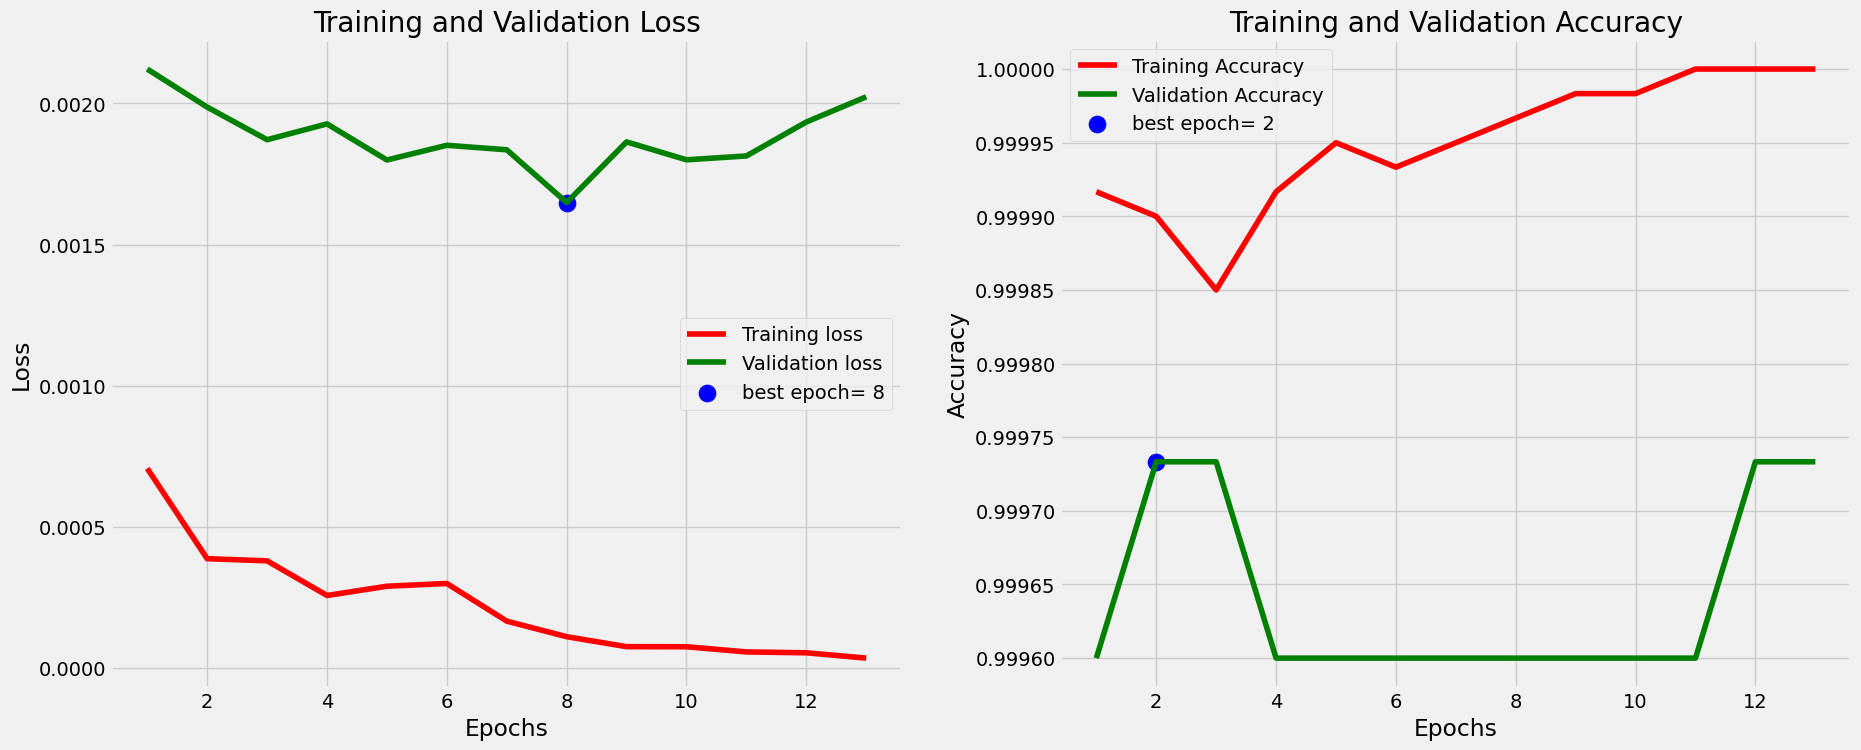

In [17]:
plot_training(history_fine)

**Evaluate Model**

In [18]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 1.0000 - loss: 1.1005e-05
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.9997 - loss: 8.7603e-04
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 1.0000 - loss: 5.7537e-04
Train Loss:  1.0145507076231297e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0005887870211154222
Validation Accuracy:  0.9998437762260437
--------------------
Test Loss:  0.0015519465086981654
Test Accuracy:  0.9998437762260437


**Confusion Matrix**

  2/118 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step

W0000 00:00:1722286568.704310      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


118/118 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step


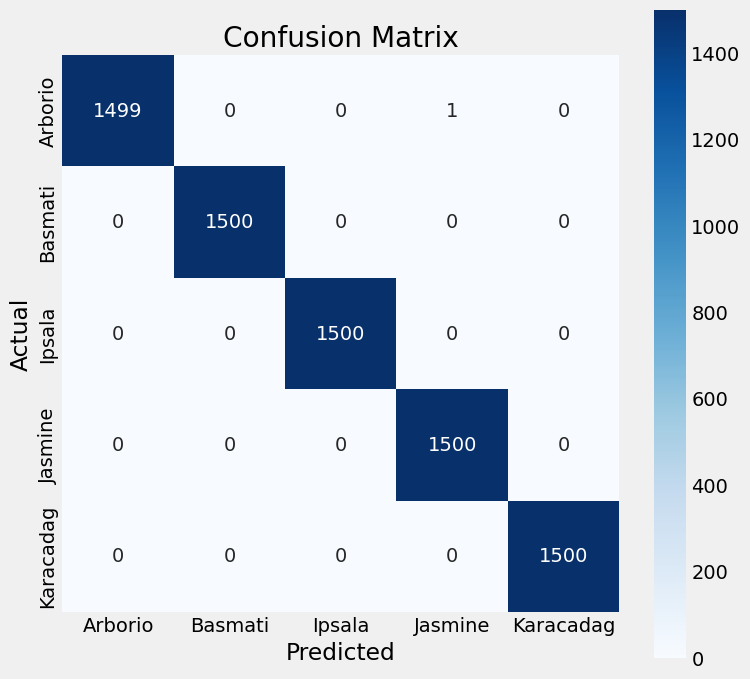

In [19]:
# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# # Plot confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()